In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

C:\Users\arwal\AppData\Local\Temp\ipykernel_4172\3429415608.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine,reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
msmnt = Base.classes.measurement
st = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
last_date = session.query(msmnt.date).order_by(msmnt.date.desc()).first()
print(f"The last date in the data set is: {last_date}")

The last date in the data set is: ('2017-08-23',)


In [23]:
one_year_ago = dt.datetime.strptime(last_date,'%Y-%m-%d') - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23 00:00:00


In [ ]:
prcp_yearly = session.query(msmnt.date,msmnt.prcp).\
    filter(msmnt.date >= "2016-08-23").all()
prcp_yearly

In [65]:
prcp_df = pd.DataFrame(prcp_yearly,columns=["Date","Precipitation"])
prcp_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [67]:
prcp_df.set_index("Date",inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


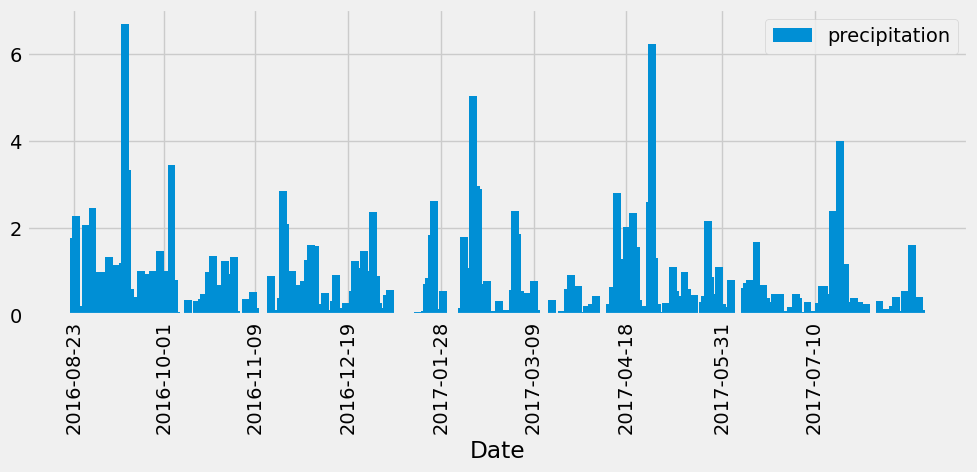

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(func.max(msmnt.date)).scalar()
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(last_date,'%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_yearly = session.query(msmnt.date,msmnt.prcp).\
    filter(msmnt.date >= "2016-08-23").all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_yearly,columns=["Date","Precipitation"])

# Sort the dataframe by date
prcp_df.set_index("Date",inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,5))
plt.bar(prcp_df.index,prcp_df['Precipitation'],width=3.4,align='center',bottom=None)

plt.legend(['precipitation'],loc='upper right')
x_ticks = ['2016-08-23','2016-10-01','2016-11-09','2016-12-19',
           '2017-01-28','2017-03-09','2017-04-18','2017-05-31','2017-07-10']
plt.xticks(x_ticks,rotation="vertical")

plt.xlabel("Date")
plt.ylabel=("Inches")
plt.tight_layout()
plt.show()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(st.id).count()

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = [msmnt.station,func.count(msmnt.id)]
stations = session.query(*most_active_stations).\
    group_by(msmnt.station).\
    order_by(func.count(msmnt.id).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = 'USC00519281'
most_active_stats = []
max_temp = session.query(func.max(msmnt.tobs)).filter(msmnt.station == most_active_id).scalar()
min_temp = session.query(func.min(msmnt.tobs)).filter(msmnt.station == most_active_id).scalar()
avg_temp = session.query(func.avg(msmnt.tobs)).filter(msmnt.station == most_active_id).scalar()
most_active_stats.append(max_temp)
most_active_stats.append(min_temp)
most_active_stats.append(avg_temp)
print(most_active_stats)

[85.0, 54.0, 71.66378066378067]


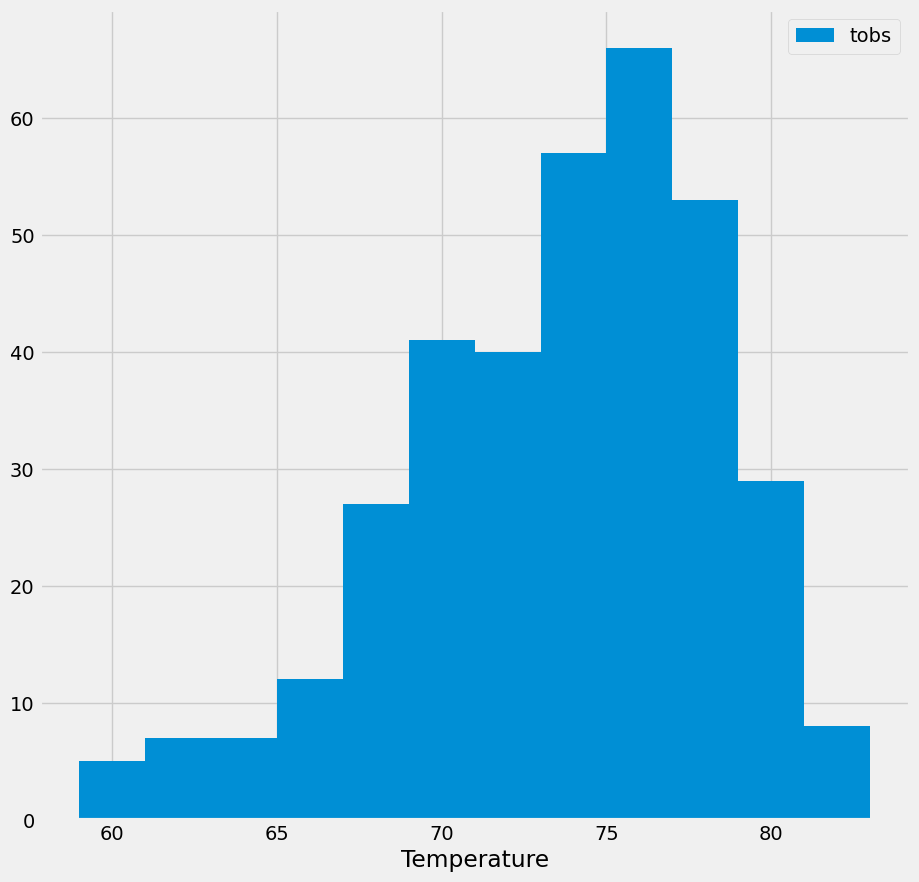

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_date = one_year_ago.strftime('%Y-%m-%d')
results = session.query(msmnt.tobs).\
            filter(msmnt.date.between(query_date,last_date),\
                   msmnt.station == 'USC00519281').all()

plt.figure(figsize=(10,10))
plt.hist(np.ravel(results),bins=12)
plt.xlabel('Temperature')
plt.legend(['tobs'],loc='upper right')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()